# Sandbox

This notebook is just intended as a trial-and-error-based playground to test different approaches.

## 0. Environmental setup

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import tifffile

sys.path.append("../..")
from src.utils.io import *
from skimage.segmentation import morphological_chan_vese, clear_border
from skimage import filters, color, measure, feature, segmentation, morphology, exposure
from scipy import ndimage as ndi


In [8]:
plt.rcParams['figure.figsize'] = [20, 10]

In [9]:
def show_plane(ax, plane, cmap="gray", title=None):
    if len(plane.shape)>2:
        plane = plane[:,:,0]
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)

        
def explore_slices(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data)

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 10))
        
        show_plane(ax, data[plane], title="Plane {}".format(plane), cmap=cmap)

        plt.show()

    return display_slice

def explore_slices_2_samples(data, cmap="gray"):
    from ipywidgets import interact
    N = min(len(data[0]),len(data[1]))

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

        show_plane(ax[0], data[0][plane], title="Plane {}".format(plane), cmap=cmap)
        show_plane(ax[1], data[1][plane], title='Plane {}'.format(plane), cmap=cmap)
        plt.show()

    return display_slice

In [10]:
def visualize_2d_image_grid(images):
    fig, ax = plt.subplots(ncols=5, nrows=len(images)//5 + len(images) % 5, figsize=[12,20])
    ax = ax.flatten()
    for i in range(len(images)):
        ax[i].imshow(images[i])
        ax[i].axis('off')
        ax[i].set_aspect('auto')
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.show()

## 1. Read in data

In [11]:
data_dir = "../../data/tcells_hv/dapi_cd8_cd4"

In [12]:
image_locs = get_file_list(data_dir)
image_locs[:5]

['../../data/tcells_hv/dapi_cd8_cd4/HV1_Tcells_DAPI_CD8_CD4_21_5_21_12bit/raw/Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1.tif',
 '../../data/tcells_hv/dapi_cd8_cd4/HV1_Tcells_DAPI_CD8_CD4_21_5_21_12bit/raw/Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_2.tif',
 '../../data/tcells_hv/dapi_cd8_cd4/HV1_Tcells_DAPI_CD8_CD4_21_5_21_12bit/raw/Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_3.tif',
 '../../data/tcells_hv/dapi_cd8_cd4/HV1_Tcells_DAPI_CD8_CD4_21_5_21_12bit/raw/Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_4.tif',
 '../../data/tcells_hv/dapi_cd8_cd4/HV1_Tcells_DAPI_CD8_CD4_21_5_21_12bit/raw/Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_5.tif']

In [13]:
images = []
for image_loc in image_locs:
    images.append(tifffile.imread(image_loc))

### 2D segmentation

In [27]:
z_projections = []
dapi_z_projections = []
for image in images:
    z_projections.append(image[:,1,:,:].max(axis=0))
    dapi_z_projections.append(image[:,0,:,:].max(axis=0))

In [17]:
visualize_2d_image_grid(z_projections)

In [18]:
filtered = []
for img in z_projections:
    filtered.append(filters.median(img))

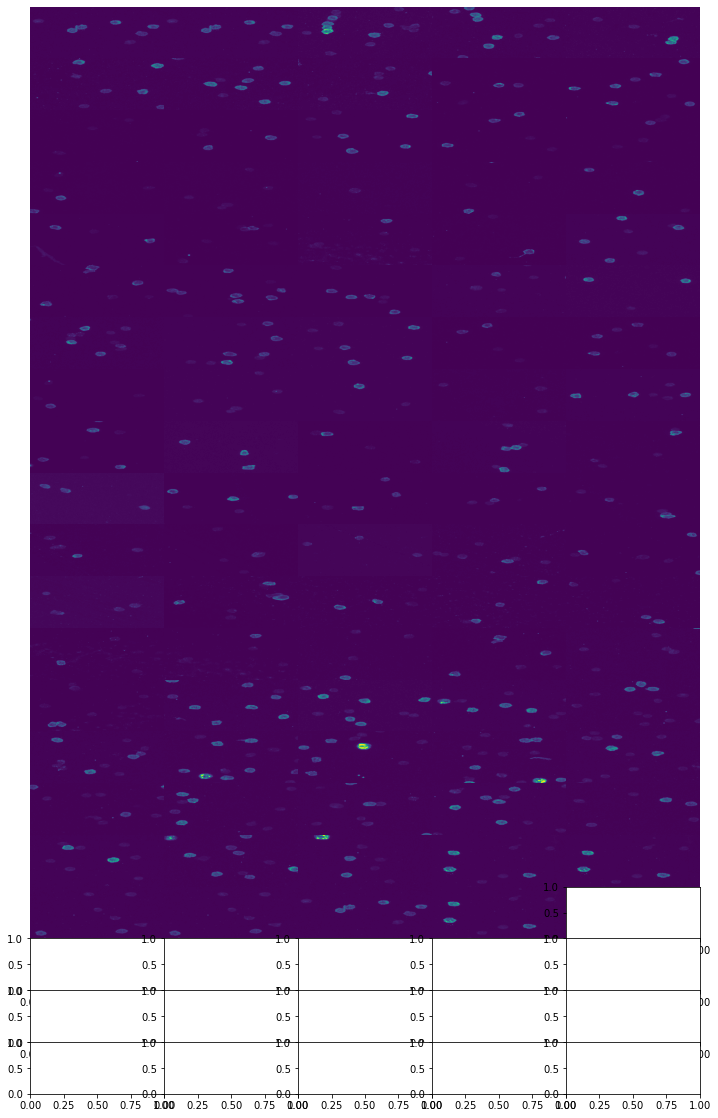

In [19]:
visualize_2d_image_grid(filtered)

In [20]:
thresholded = []
for img in filtered:
    img = exposure.adjust_gamma(img, 1.0)
    t = filters.threshold_otsu(img)
    binary = img > t
    binary = segmentation.clear_border(binary)
    thresholded.append(morphology.remove_small_objects(ndi.binary_fill_holes(binary),100))

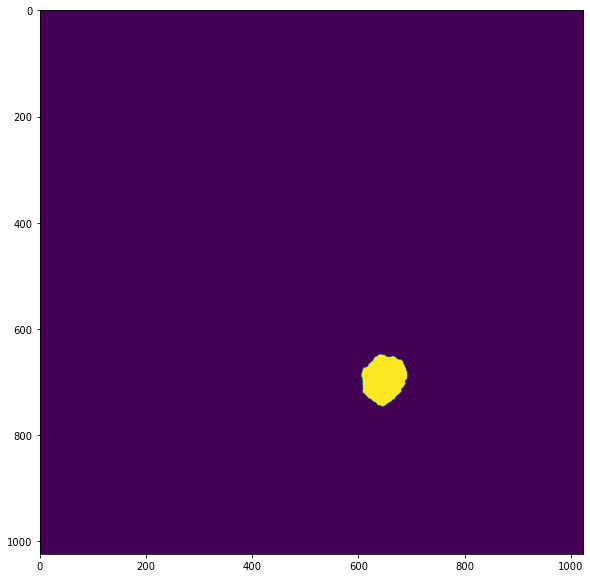

In [40]:
plt.imshow(thresholded[7])

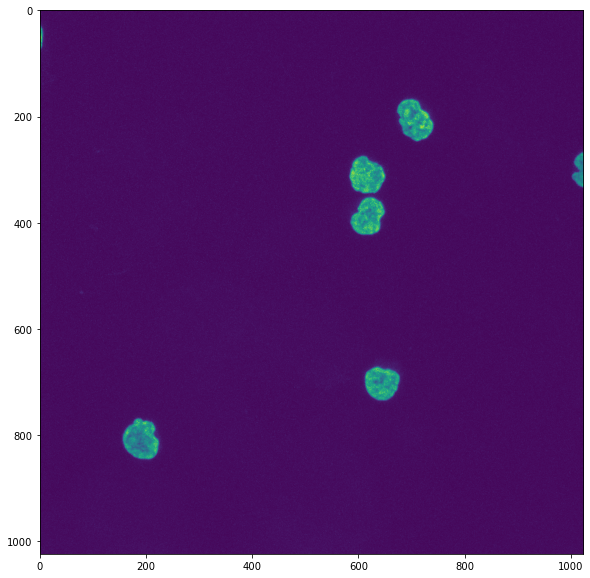

In [41]:
plt.imshow(dapi_z_projections[7])

In [437]:
segmented = []
for image in thresholded:
    d = ndi.distance_transform_edt(image)
    markers = d>d.max() * 0.5
    markers = morphology.erosion(markers)
    markers = measure.label(markers)
    segmented.append(segmentation.watershed(-d, markers, mask=image))

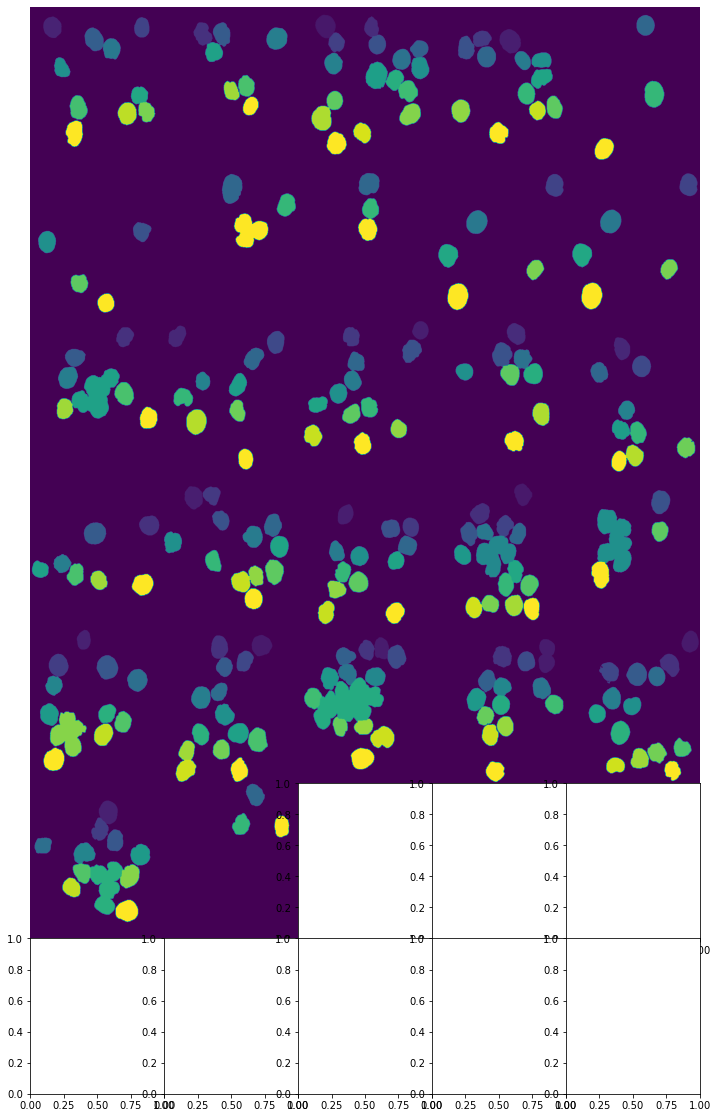

In [438]:
visualize_2d_image_grid(segmented)

In [409]:
visualize_2d_image_grid(segmented)

In [439]:
all_segmented_nuclei = []
for i in range(len(segmented)):
    segmented_nuclei = []
    regions = measure.regionprops(segmented[i], intensity_image=z_projections[i])
    for region in regions:
        w, h = region.intensity_image.shape
        if min(w,h)/max(w,h) > 0.8 and region.convex_area < 6000 :
            xmin,ymin,xmax,ymax = region.bbox
            #segmented_nuclei.append(z_projections[i][xmin:xmax+1, ymin:ymax+1])
            all_segmented_nuclei.append(region.intensity_image)
            segmented_nuclei.append(images[i][:,xmin:xmax+1, ymin:ymax+1,:])

In [441]:
print('[INFO] Segmented {} nuclei.'.format(len(all_segmented_nuclei)))

[INFO] Segmented 216 nuclei.


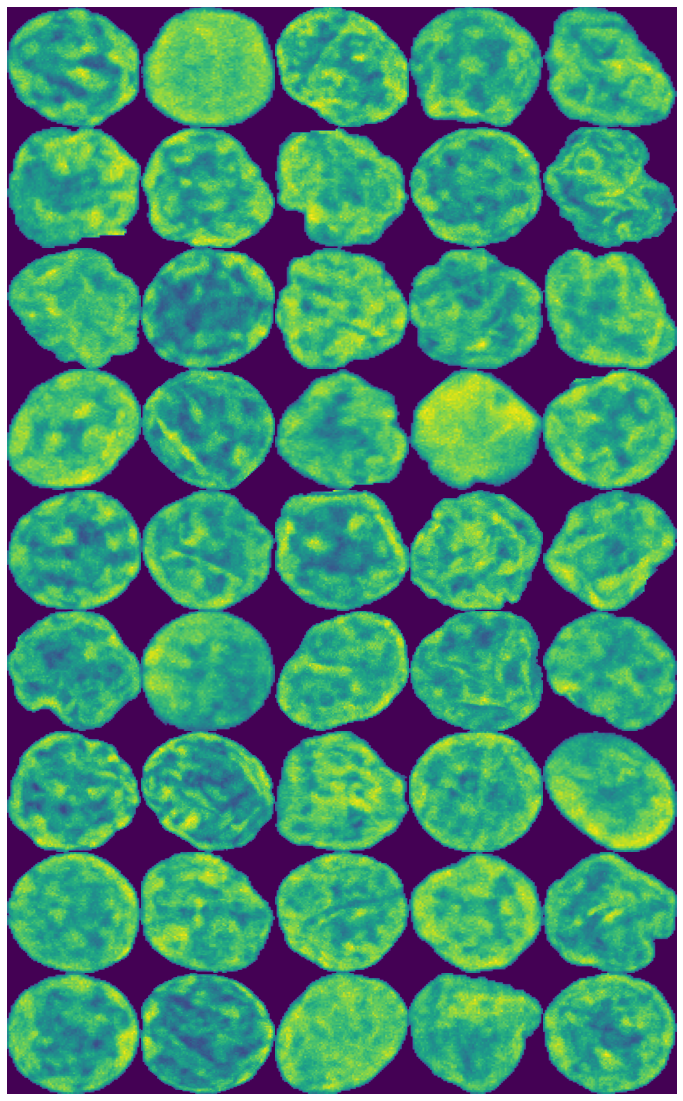

In [443]:
visualize_2d_image_grid(all_segmented_nuclei[:45])

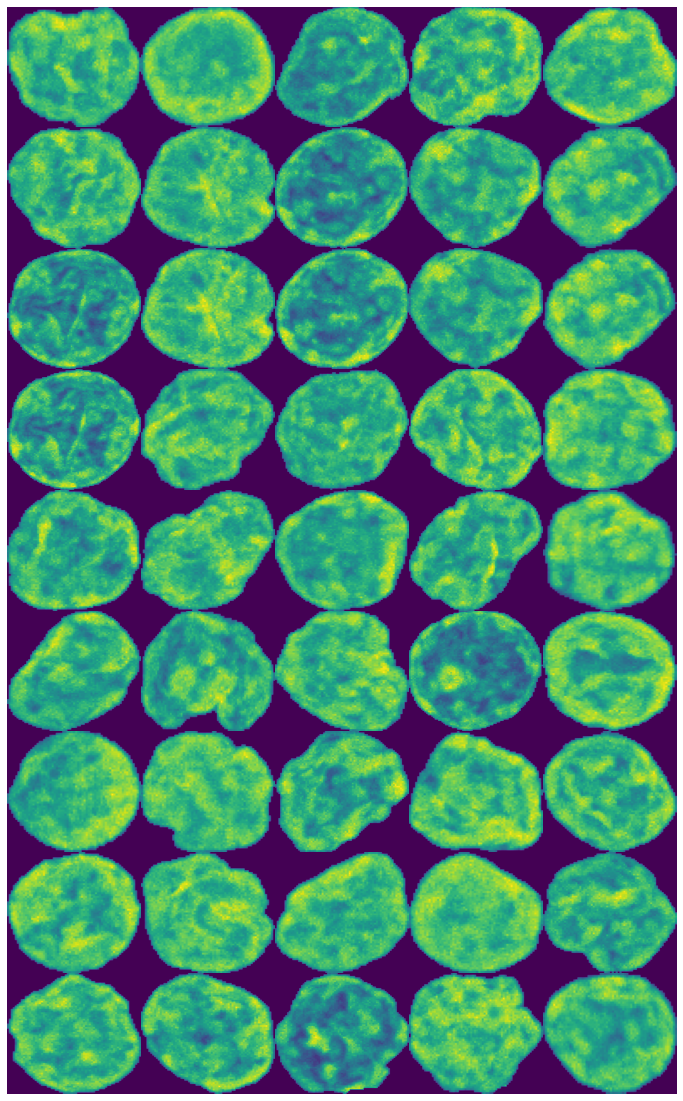

In [444]:
visualize_2d_image_grid(all_segmented_nuclei[45:90])

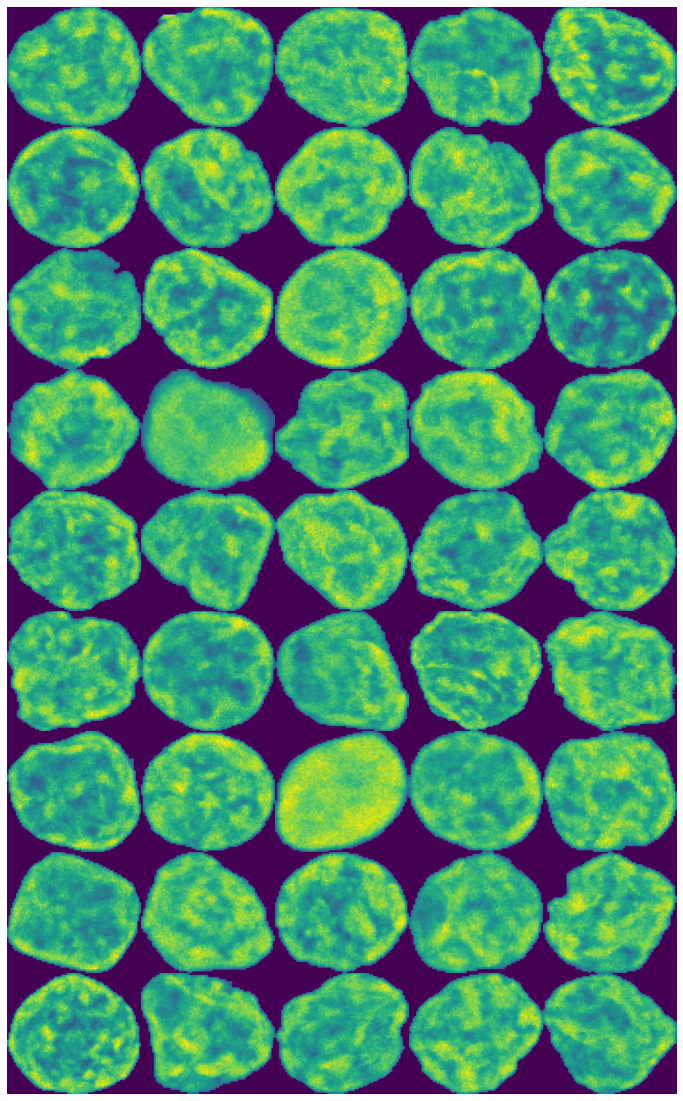

In [445]:
visualize_2d_image_grid(all_segmented_nuclei[90:135])

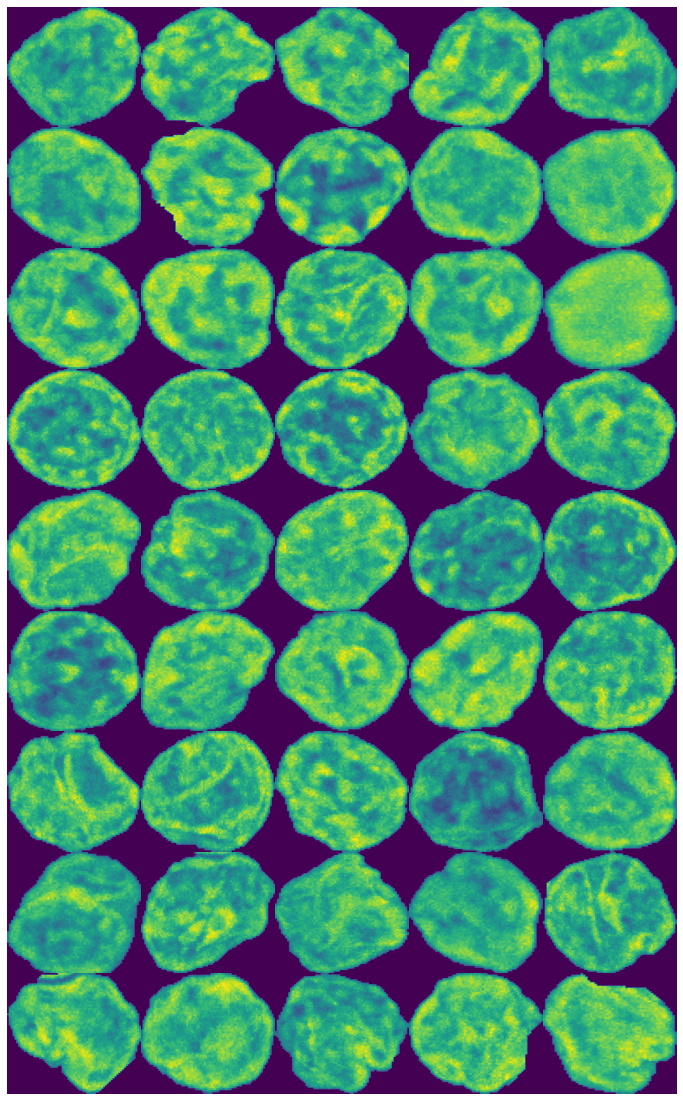

In [446]:
visualize_2d_image_grid(all_segmented_nuclei[135:180])

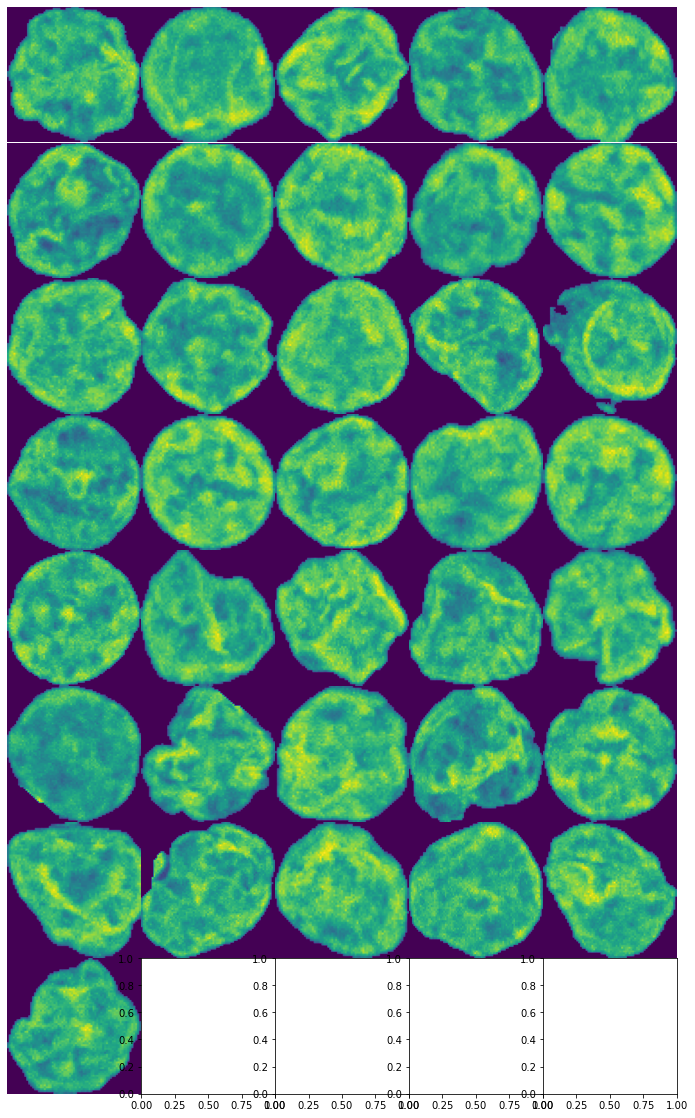

In [448]:
visualize_2d_image_grid(all_segmented_nuclei[180:])